In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from numpy import linalg as LA
import torch.optim as optim

torch.autograd.set_detect_anomaly(True)

#multi-dimensional
N, T = 5, 1

x = torch.rand((N, T))
x_bar = torch.rand((N, T))
lambda_param = 1

alpha_lst = torch.ones(N)
ALPHA = 100
m = nn.Softmax()
p = torch.rand(T)

In [4]:
def f_i(x_i, x_bar_i, p):
    return (1/2)*torch.norm(x_i - x_bar_i)**2 + x_i@p

def externality_calc(x):
    z = torch.sum(x, dim=0)
    return z**2

In [5]:
#step sizes
gamma = 0.5
beta = 0.3


print("p is ", p)

player_actions = []
for j in range(N):
    curr_action = torch.rand(T) 
    player_actions.append(curr_action) 
player_actions = torch.stack(player_actions)

p_traj = []
x_traj = []

prev_actions = None 
for e in range(50):
    print('=', end='')
    for i in range(N):
        #print("index: ", i)
        curr_action = torch.nn.Parameter(player_actions[i])
        best_response_optimizer = torch.optim.SGD([curr_action], lr = 1e-4, momentum = 0.8)
        prev_loss = torch.tensor(1e6)
        output_action = torch.relu(curr_action) #torch.clamp(curr_action, 0, 1)
        for epoch in range(100):
            best_response_optimizer.zero_grad()
            loss = f_i(output_action, x_bar[i], p)
            loss.backward()
            best_response_optimizer.step()
            output_action = torch.relu(curr_action)
            if torch.isclose(torch.abs(prev_loss-loss).float(), torch.tensor(float(0.0))):
                break
            else: 
                prev_loss = loss 
        player_actions[i] = gamma * output_action.detach() + (1-gamma) * player_actions[i].clone()
    #print("after optimization: ", output_action)
    externality = externality_calc(player_actions)
    p = (1-beta)*p + externality * beta
    
        
#     if prev_actions != None:
#         dist = torch.norm(player_actions - prev_actions)
#         break
    x_traj.append(player_actions.clone())
    p_traj.append(p.clone())
    prev_actions = player_actions.clone()
equilibrium_actions = player_actions.clone()

#x_traj = torch.concat(x_traj, axis=1).T
# p_traj = torch.concat(p_traj)

p is  tensor([0.8230])

In [6]:
x_traj = torch.stack(x_traj)

In [7]:
x_traj[:, 0, :].shape

torch.Size([50, 1])

In [66]:
x_traj.shape

torch.Size([200, 5])

In [67]:
p_traj.shape

torch.Size([50, 4])

Text(0.5, 1.0, 'action trajectory')

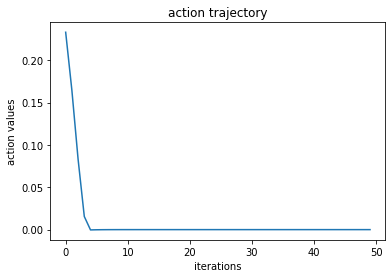

In [8]:
plt.plot(x_traj[:, 0, :])
plt.xlabel("iterations")
plt.ylabel("action values")
plt.title("action trajectory")

Text(0.5, 1.0, 'user strategy trajectory')

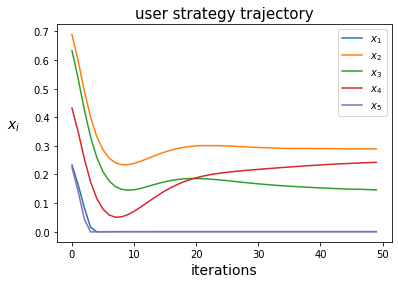

In [23]:
plt.plot(x_traj[:, 0], label=r"$x_1$")
plt.plot(x_traj[:, 1], label=r"$x_2$")
plt.plot(x_traj[:, 2], label=r"$x_3$")
plt.plot(x_traj[:, 3], label=r"$x_4$")
plt.plot(x_traj[:, 4], label=r"$x_5$")
plt.xlabel("iterations", fontsize=14)
plt.ylabel(r"$x_i$", rotation='horizontal', labelpad = 20, fontsize=14)
plt.legend()
plt.title("user strategy trajectory", fontsize=15)

Text(0.5, 1.0, 'system total demand trajectory')

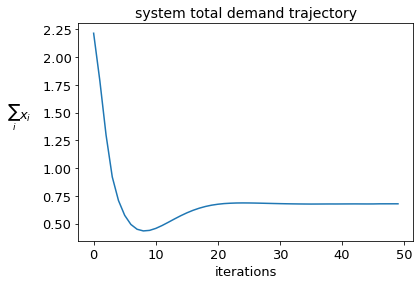

In [19]:
plt.plot(torch.sum(x_traj, dim=1))
plt.xlabel("iterations", fontsize=13)
plt.ylabel(r"$\sum_{i} x_i$",  rotation='horizontal', labelpad = 23, fontsize=13)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("system total demand trajectory", fontsize=14)

Text(0.5, 1.0, 'adaptive incentive trajectory')

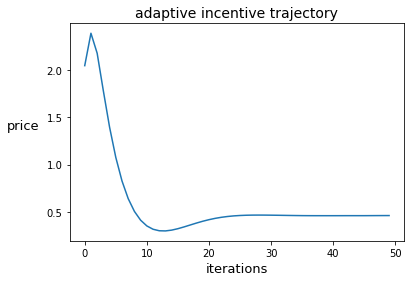

In [18]:
plt.plot(p_traj)
plt.xlabel("iterations", fontsize=13)
plt.ylabel("price", rotation='horizontal', labelpad = 23, fontsize=13)
plt.title("adaptive incentive trajectory", fontsize=14)

In [229]:
import pickle
with open('p_traj.pkl','wb') as f:
     pickle.dump(p_traj.numpy(), f)

Text(0.5, 1.0, 'initial total load')

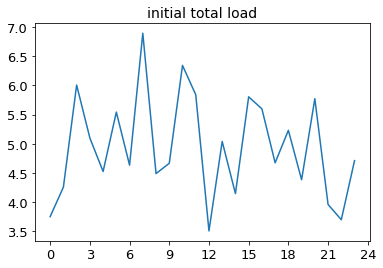

In [172]:
plt.plot(torch.sum(x_traj, dim=1)[0, :])
plt.xticks(np.arange(0, 27, 3))
# plt.xlabel("go", fontsize=13)
# plt.ylabel(r"$\sum_{i} x_i$",  rotation='horizontal', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("initial total load", fontsize=14)

Text(0.5, 1.0, 'final total load')

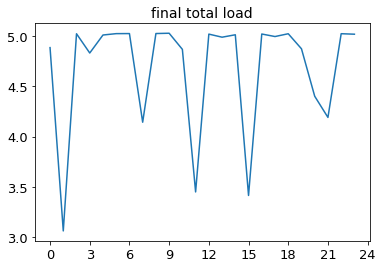

In [177]:
plt.plot(torch.sum(x_traj, dim=1)[-1, :])
plt.xticks(np.arange(0, 27, 3))
# plt.xlabel("go", fontsize=13)
# plt.ylabel(r"$\sum_{i} x_i$",  rotation='horizontal', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("final total load", fontsize=14)

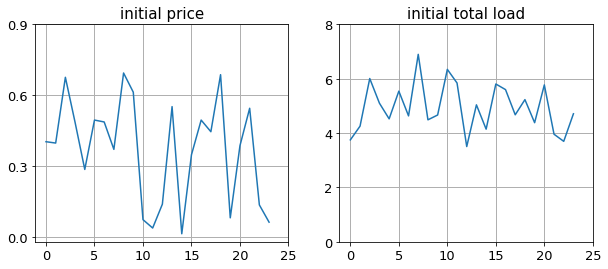

In [216]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax2.plot(torch.sum(x_traj, dim=1)[0, :])

ax2.set_title("initial total load", fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.set_xticks(np.arange(0, 27, 5))
ax2.set_yticks(np.arange(0, 9, 2))
ax2.grid(linewidth=1)
ax1.plot(p_traj[0, :])
ax1.set_title("initial price", fontsize=15)
ax1.set_xticks(np.arange(0, 27, 5))
ax1.set_yticks(np.arange(0, 1, 0.3))
ax1.grid(linewidth=1)
ax1.tick_params(axis='both', which='major', labelsize=13)


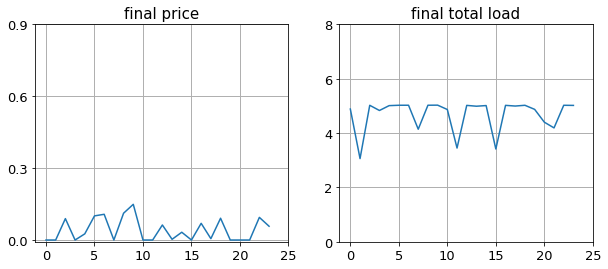

In [217]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(p_traj[-1, :])
ax1.set_title("final price", fontsize=15)
ax1.set_xticks(np.arange(0, 27, 5))
ax1.set_yticks(np.arange(0, 1, 0.3))
ax1.grid(linewidth=1)
ax1.tick_params(axis='both', which='major', labelsize=13)
ax2.plot(torch.sum(x_traj, dim=1)[-1, :])
ax2.set_title("final total load", fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.set_xticks(np.arange(0, 27, 5))
ax2.set_yticks(np.arange(0, 9, 2))
ax2.grid(linewidth=1)